<a href="https://colab.research.google.com/github/GoogleCloudPlatform/training-data-analyst/blob/master/courses/fast-and-lean-data-science/02_Dataset_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
import os, math
import numpy as np
from matplotlib import pyplot as plt
os.environ['GCS_READ_CACHE_MAX_SIZE_MB'] = '1' # Little wrinkle: this hack is needed to work around a Colab/GCS cache OOM bug
import tensorflow as tf
tf.enable_eager_execution()

In [0]:
#@title "display utilities [RUN ME]"
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label, one_hot_label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8") + ' ' + str(one_hot_label.numpy()), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## Colab auth

In [0]:
from google.colab import auth
auth.authenticate_user()
# Little wrinkle: without auth, Colab will be extremely slow in accessing data from a GCS bucket, even public

## Configuration

In [0]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # flower labels (folder names in the data)

## Read images and labels [WORK REQUIRED]
1. Use `fileset=`[`tf.data.Dataset.list_files`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) to scan the data folder
1. Iterate through the dataset of filenames: `for filename in fileset:...` . 
 * Does it work ?
 * No! But Python iteration though a Dataset works in eager mode. Enable eager mode in the first cell, restart the runtime and try again.
  * It works but why are Tensors returned ? Get proper values by applyting .numpy() to the tensors.
1. Use [tf.data.Dataset.map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to decode the JPEG files. You will find useful TF code snippets below.
 * Iterate on the image dataset. You can use .numpy().shape to only see the data sizes.
  * Are all images of the same size ?
1. Now create a training dataset: you have images but you also need labels:
 *  the labels (flower names) are the directory names. You will find useful TF code snippets below for parsing them.
 * If you do "`return image, label`" in the decoding function. You will have a Dataset of pairs (image, label).
 * The function  `decode_jpeg_and_label` in the snippets below adds a third value: the one-hot encoded label. It will be useful for training.
1. Look at the flowers with the `display_9_images_from_dataset` function. It expects the Dataset to have `(image, label, one_hot_label)` elements.
1. Code for iterating on a dataset in non-eager mode is also provided in the snippets below. Have a look, it is a bit more complex...

Pattern matches 3670 images.
gs://flowers-public/sunflowers/5139971615_434ff8ed8b_n.jpg
gs://flowers-public/daisy/8094774544_35465c1c64.jpg
gs://flowers-public/sunflowers/9309473873_9d62b9082e.jpg
gs://flowers-public/dandelion/19551343954_83bb52f310_m.jpg
gs://flowers-public/dandelion/14199664556_188b37e51e.jpg
gs://flowers-public/tulips/4290566894_c7f061583d_m.jpg
gs://flowers-public/roses/3065719996_c16ecd5551.jpg
gs://flowers-public/dandelion/8168031302_6e36f39d87.jpg
gs://flowers-public/sunflowers/9564240106_0577e919da_n.jpg
gs://flowers-public/daisy/14167543177_cd36b54ac6_n.jpg
(336, 500, 3)
(333, 500, 3)
(240, 320, 3)
(333, 500, 3)
(213, 320, 3)
(240, 320, 3)
(240, 240, 3)
(333, 500, 3)
(240, 320, 3)
(375, 500, 3)
(331, 500, 3) daisy [1 0 0 0 0]
(240, 180, 3) tulips [0 0 0 0 1]
(334, 500, 3) roses [0 0 1 0 0]
(240, 320, 3) sunflowers [0 0 0 1 0]
(240, 320, 3) sunflowers [0 0 0 1 0]
(228, 320, 3) tulips [0 0 0 0 1]
(325, 500, 3) daisy [1 0 0 0 0]
(240, 320, 3) daisy [1 0 0 0 0]
(2

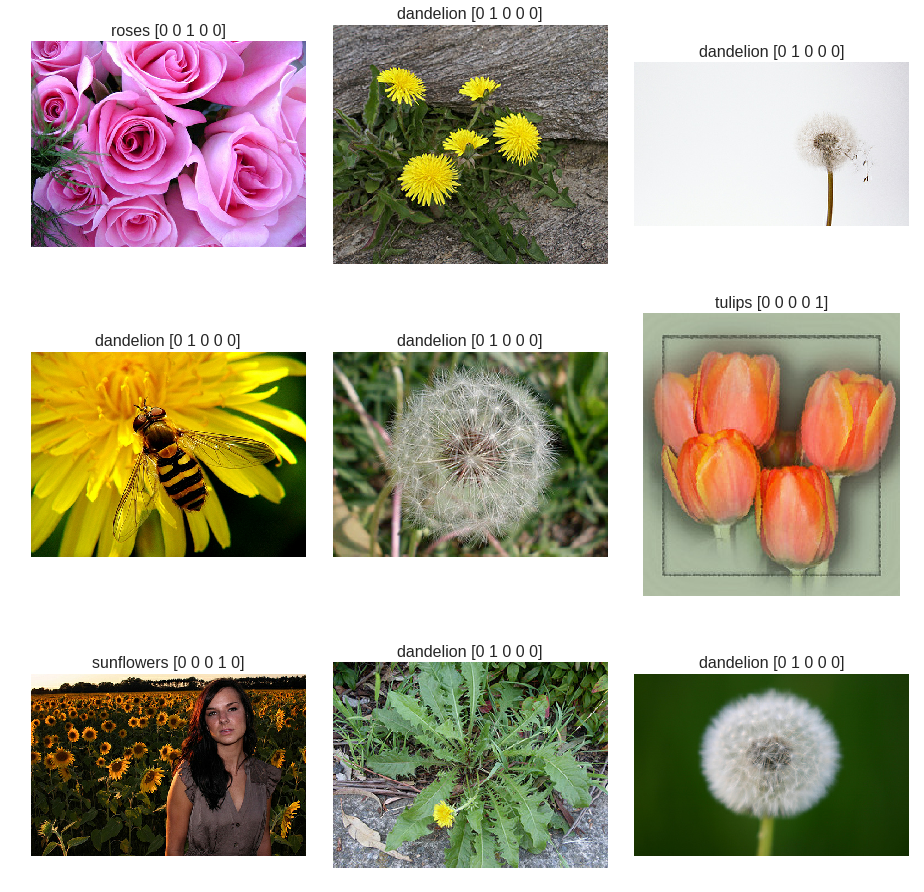

In [0]:
nb_images = len(tf.gfile.Glob(GCS_PATTERN))
print("Pattern matches {} images.".format(nb_images))

### QUESTIONS 1. and 2.
filenames_dataset = tf.data.Dataset.list_files(GCS_PATTERN)
for filename in filenames_dataset.take(10):
  print(filename.numpy().decode('utf-8'))
  
### QUESTION 3.

# copy-pasted from "useful code snippets" below
def decode_jpeg(filename):
  bits = tf.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  return image

image_dataset = filenames_dataset.map(decode_jpeg)
for image in image_dataset.take(10):
  print(image.numpy().shape)
  
### QUESTION 4.

# copy-pasted from "useful code snippets" below
def decode_jpeg_and_label(filename):
  bits = tf.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  one_hot_label = tf.tile(tf.expand_dims(label, axis=-1), [len(CLASSES)])
  one_hot_label = tf.cast(tf.math.equal(one_hot_label, CLASSES), tf.uint8)
  return image, label, one_hot_label

dataset = filenames_dataset.map(decode_jpeg_and_label)
for image, label, one_hot_label in dataset.take(10):
  print(image.numpy().shape, label.numpy().decode('utf-8'), one_hot_label.numpy())

  ### QUESTION 5.
display_9_images_from_dataset(dataset)

## Useful code snippets

### Decode a JPEG in Tensorflow

In [0]:
def decode_jpeg(filename):
  bits = tf.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  return image

### Decode a JPEG and extract folder name in Tensorflow

In [0]:
def decode_jpeg_and_label(filename):
  bits = tf.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  one_hot_label = tf.tile(tf.expand_dims(label, axis=-1), [len(CLASSES)])
  one_hot_label = tf.cast(tf.math.equal(one_hot_label, CLASSES), tf.uint8)
  return image, label, one_hot_label

### Read from dataset in non-eager mode

In [0]:
assert not tf.executing_eagerly(), "This cell will only work in non-eager mode"

next_data_item = dataset.make_one_shot_iterator().get_next()
with tf.Session() as ses:
  while True:
    try:
      image, label, one_hot_label = ses.run(next_data_item)
      # ses.run returns numpy data
      print(image.shape, label, one_hot_label)
    except tf.errors.OutOfRangeError:
      print("the end")
      break;

AssertionError: ignored